In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 15 14:49:58 2022

@author: Sidi Wu and Cédric Beaulac

Functional autoencoder implementation
"""

# Import modules
import torch
import torch.nn.init as init
import torch.nn.functional as F
import torch.nn as nn

from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import numpy as np
from numpy import *
import seaborn as sns
import matplotlib
#matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
# import skfda as fda
# from skfda import representation as representation
# from skfda.exploratory.visualization import FPCAPlot
# # from skfda.exploratory.visualization import FPCAPlot
# # from skfda.preprocessing.dim_reduction import FPCA
# # from skfda.representation.basis import BSpline, Fourier, Monomial
import scipy
from scipy.interpolate import BSpline
import os
import ignite
import sklearn
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
import random
from random import seed
from scipy import stats
import statistics
from statistics import stdev

import skfda
from skfda import FDataGrid as fd
from skfda.representation.basis import BSpline as B


In [2]:
import pandas as pd
import os
os.chdir("C:/Users/Utilisateur/Documents/Master_SSD/STAGE_RECHERCHE/Functionnal Classifier")
# Lire le fichier CSV
sofa = pd.read_csv('sofa.csv')
T=20
# Attribuer des noms de colonnes personnalisés


# Afficher les noms de colonnes
print(sofa.columns)
grid_points=np.arange(T+1)[1:]
sofa.values.shape


Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173',
       'V174'],
      dtype='object', length=174)


(520, 174)

In [3]:
Y_X=torch.from_numpy(sofa.values).float().cuda()

y,x=Y_X[:,0].unsqueeze(1).unsqueeze(2).long(),Y_X[:,1:T+1].reshape(520,1,T)
x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(x,y,shuffle=True)
x_train.shape,y_train.shape


(torch.Size([390, 1, 20]), torch.Size([390, 1, 1]))

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_9256\215658973.py:10: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval = basis.evaluate(eval_points=eval_points)[:, :, 0]


(6, 5000) (390, 6)
torch.Size([6, 5000])


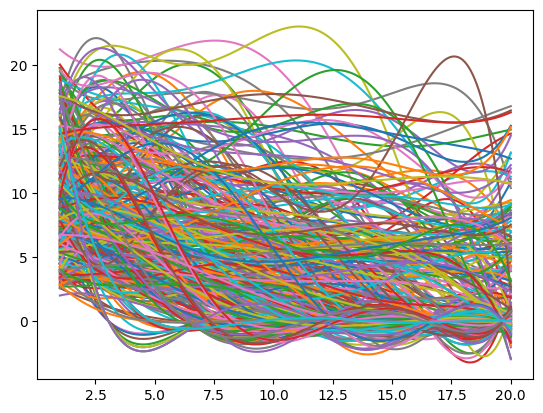

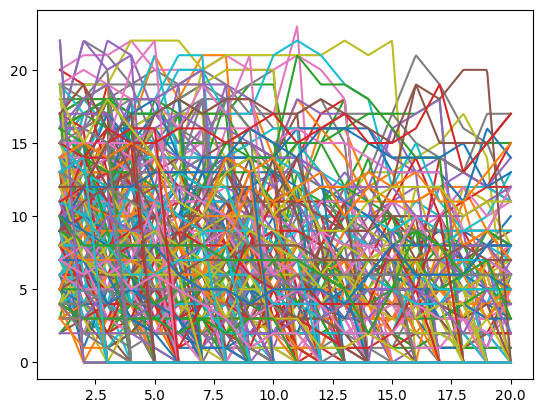

In [4]:
eval_points=linspace(1,T,5000)
eval_points
x_train_grid=fd(x_train[:,0,:].cpu(),grid_points=grid_points)
  # Valeur de départ
  # Valeur de fin

basis=B(knots=linspace(1,T,2),order=6)
# basis=skfda.representation.basis.MonomialBasis()

basis_eval = basis.evaluate(eval_points=eval_points)[:, :, 0]
print(basis_eval.shape,fd(x_train[:,0,:].cpu()).to_basis(basis).coefficients.shape)
basis_fc = torch.from_numpy(basis_eval).float().cuda()
n_basis=basis.n_basis
print(basis_fc.shape)
x_train_grid.to_basis(basis).plot()
plt.show()
x_train_grid.plot()
plt.show()

In [5]:
coefs=fd(x_train[:,0,:].cpu(),grid_points=grid_points).to_basis(basis=basis).coefficients
coefs_torch=torch.tensor(coefs).cuda()


coefs_torch.shape

torch.Size([390, 6])

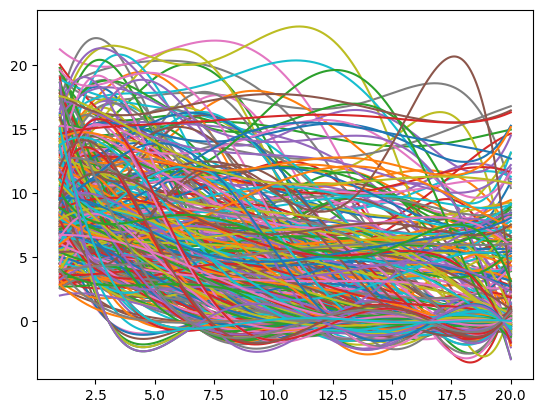

torch.Size([390, 5000])

In [6]:
Recons=torch.matmul(coefs_torch.cuda().float(),basis_fc)
fd(Recons.cpu(),grid_points=eval_points).plot()
plt.show()
Recons.shape

In [7]:

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.04)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.04)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [1352]:
##Hyper Paramètres:
basis=B(knots=linspace(1,T,9),order=3)
n_conv_out=1
granulation=2000
n_conv_in=128
n_conv_in2=128
n_conv_in3=64
n_Flat_out=128
stride_1=8
stride_2=2
stride_3=1
stride_pool_1=1
stride_pool_2=1
stride_pool_3=1 
kernel_size_1=300
kernel_size_2=100
kernel_size_3=75
kernel_size_pool_1=10
kernel_size_pool_2=4
kernel_size_pool_3=2
dilation_1=1
dilation_2=1
dilation_3=1
dilation_pool_1=1
dilation_pool_2=1
dilation_pool_3=1
padding_1=2
padding_2=2
padding_3=2
padding_pool_1=1
padding_pool_2=1
padding_pool_3=1



In [353]:

class Smooth_Strides_FCNN(nn.Module):
    def __init__(self,
n_conv_out=n_conv_out,
n_conv_in=n_conv_in,
n_conv_in2=n_conv_in2,
n_conv_in3=n_conv_in3,
n_Flat_out=n_Flat_out,
stride_1=stride_1,
stride_2=stride_2,
stride_3=stride_3,
stride_pool_1=stride_pool_1,
stride_pool_2=stride_pool_2,
stride_pool_3=stride_pool_3,
kernel_size_1=kernel_size_1,
kernel_size_2=kernel_size_2,
kernel_size_3=kernel_size_3,
kernel_size_pool_1=kernel_size_pool_1,
kernel_size_pool_2=kernel_size_pool_2,
kernel_size_pool_3=kernel_size_pool_3,
dilation_1=dilation_1,
dilation_2=dilation_2,
dilation_3=dilation_3,
dilation_pool_1=dilation_pool_1,
dilation_pool_2=dilation_pool_2,
dilation_pool_3=dilation_pool_3):
        super(Smooth_Strides_FCNN,self).__init__()

        self.Relu=nn.ReLU()

        self.convlayer1=nn.Sequential(
            nn.Conv1d(1,n_conv_in,kernel_size=kernel_size_1,stride=stride_1,padding=padding_1,dilation=dilation_1),
            nn.BatchNorm1d(n_conv_in),
            nn.LeakyReLU(0.18),
            
            nn.MaxPool1d(kernel_size=kernel_size_pool_1,stride=stride_pool_1,padding=padding_pool_1,dilation=dilation_pool_1),
            nn.BatchNorm1d(n_conv_in),
            nn.LeakyReLU(0.18),
        )
        
        self.convlayer2=nn.Sequential(
            nn.Conv1d(n_conv_in,n_conv_in2,kernel_size=kernel_size_2,stride=stride_2,padding=padding_2,dilation=dilation_2),
            nn.BatchNorm1d(n_conv_in2),
            nn.LeakyReLU(0.18),
            
            nn.MaxPool1d(kernel_size=kernel_size_pool_2,stride=stride_pool_2,padding=padding_pool_2,dilation=dilation_pool_2),
            nn.BatchNorm1d(n_conv_in2),
            nn.LeakyReLU(0.18),
        )
        
        self.convlayer3=nn.Sequential(

            nn.Conv1d(n_conv_in2,n_conv_in3,kernel_size=kernel_size_3,stride=stride_3,padding=padding_3,dilation=dilation_3),
            nn.BatchNorm1d(n_conv_in3),
            nn.LeakyReLU(0.18),
            
            nn.MaxPool1d(kernel_size=kernel_size_pool_3,stride=stride_pool_3,padding=padding_pool_3,dilation=dilation_pool_3),
            nn.BatchNorm1d(n_conv_in3),
            nn.LeakyReLU(0.18),
        )

        self.fc_block=nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_conv_out*n_conv_in3,n_Flat_out),
            nn.BatchNorm1d(n_Flat_out),
            nn.LeakyReLU(0.18),
            
            nn.Linear(n_Flat_out,2),
            
        )
        self.activation=nn.Softmax()
        self.n_conv_out=n_conv_out
    def Granulator(self,x):
        eval_points=linspace(1,T,granulation)
        basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
        basis_fc = torch.from_numpy(basis_eval).float().cuda()
        coefs=fd(x[:,0,:].cpu(),grid_points=grid_points).to_basis(basis=basis).coefficients
        
        coefs_torch=torch.tensor(coefs).float().cuda()
        Recons_train=torch.matmul(coefs_torch,basis_fc)
        Recons_train=Recons_train.reshape(Recons_train.shape[0],1,Recons_train.shape[1])
        return Recons_train

    def forward(self,x):
        Granulated_x_train=self.Granulator(x)
        tresh_out=torch.relu(Granulated_x_train)
        Conv_out=self.convlayer1(tresh_out)
        Conv_out2=self.convlayer2(Conv_out)
        Conv_out3=self.convlayer3(Conv_out2)
        Lin_out=self.fc_block(Conv_out3)
        return Lin_out.float().unsqueeze_(2).unsqueeze_(3)


In [362]:

def Compile_class(
        n_conv_out=n_conv_out,
        n_conv_in=n_conv_in,
        n_conv_in2=n_conv_in2,
        n_conv_in3=n_conv_in3,
        n_Flat_out=n_Flat_out,
        stride_1=stride_1,
        stride_2=stride_2,
        stride_3=stride_3,
        stride_pool_1=stride_pool_1,
        stride_pool_2=stride_pool_2,
        stride_pool_3=stride_pool_3,
        kernel_size_1=kernel_size_1,
        kernel_size_2=kernel_size_2,
        kernel_size_3=kernel_size_3,
        kernel_size_pool_1=kernel_size_pool_1,
        kernel_size_pool_2=kernel_size_pool_2,
        kernel_size_pool_3=kernel_size_pool_3,
        dilation_1=dilation_1,
        dilation_2=dilation_2,
        dilation_3=dilation_3,
        dilation_pool_1=dilation_pool_1,
        dilation_pool_2=dilation_pool_2,
        dilation_pool_3=dilation_pool_3,
    ):
    module=Smooth_Strides_FCNN(
        n_conv_out=n_conv_out,
        n_conv_in=n_conv_in,
        n_conv_in2=n_conv_in2,
        n_conv_in3=n_conv_in3,
        n_Flat_out=n_Flat_out,
        stride_1=stride_1,
        stride_2=stride_2,
        stride_3=stride_3,
        stride_pool_1=stride_pool_1,
        stride_pool_2=stride_pool_2,
        stride_pool_3=stride_pool_3,
        kernel_size_1=kernel_size_1,
        kernel_size_2=kernel_size_2,
        kernel_size_3=kernel_size_3,
        kernel_size_pool_1=kernel_size_pool_1,
        kernel_size_pool_2=kernel_size_pool_2,
        kernel_size_pool_3=kernel_size_pool_3,
        dilation_1=dilation_1,
        dilation_2=dilation_2,
        dilation_3=dilation_3,
        dilation_pool_1=dilation_pool_1,
        dilation_pool_2=dilation_pool_2,
        dilation_pool_3=dilation_pool_3)
    n_conv_out=CNN.n_conv_out
    class Bsp_classifier(nn.Module):
        def __init__(self,
    n_conv_out=n_conv_out,
    n_conv_in=n_conv_in,
    n_conv_in2=n_conv_in2,
    n_conv_in3=n_conv_in3,
    n_Flat_out=n_Flat_out,
    stride_1=stride_1,
    stride_2=stride_2,
    stride_3=stride_3,
    stride_pool_1=stride_pool_1,
    stride_pool_2=stride_pool_2,
    stride_pool_3=stride_pool_3,
    kernel_size_1=kernel_size_1,
    kernel_size_2=kernel_size_2,
    kernel_size_3=kernel_size_3,
    kernel_size_pool_1=kernel_size_pool_1,
    kernel_size_pool_2=kernel_size_pool_2,
    kernel_size_pool_3=kernel_size_pool_3,
    dilation_1=dilation_1,
    dilation_2=dilation_2,
    dilation_3=dilation_3,
    dilation_pool_1=dilation_pool_1,
    dilation_pool_2=dilation_pool_2,
    dilation_pool_3=dilation_pool_3):
            super(Bsp_classifier,self).__init__()

            self.Relu=nn.ReLU()

            self.convlayer1=nn.Sequential(
                nn.Conv1d(1,n_conv_in,kernel_size=kernel_size_1,stride=stride_1,padding=padding_1,dilation=dilation_1),
                nn.BatchNorm1d(n_conv_in),
                nn.LeakyReLU(0.18),
                
                nn.MaxPool1d(kernel_size=kernel_size_pool_1,stride=stride_pool_1,padding=padding_pool_1,dilation=dilation_pool_1),
                nn.BatchNorm1d(n_conv_in),
                nn.LeakyReLU(0.18),
            )
            
            self.convlayer2=nn.Sequential(
                nn.Conv1d(n_conv_in,n_conv_in2,kernel_size=kernel_size_2,stride=stride_2,padding=padding_2,dilation=dilation_2),
                nn.BatchNorm1d(n_conv_in2),
                nn.LeakyReLU(0.18),
                
                nn.MaxPool1d(kernel_size=kernel_size_pool_2,stride=stride_pool_2,padding=padding_pool_2,dilation=dilation_pool_2),
                nn.BatchNorm1d(n_conv_in2),
                nn.LeakyReLU(0.18),
            )
            
            self.convlayer3=nn.Sequential(

                nn.Conv1d(n_conv_in2,n_conv_in3,kernel_size=kernel_size_3,stride=stride_3,padding=padding_3,dilation=dilation_3),
                nn.BatchNorm1d(n_conv_in3),
                nn.LeakyReLU(0.18),
                
                nn.MaxPool1d(kernel_size=kernel_size_pool_3,stride=stride_pool_3,padding=padding_pool_3,dilation=dilation_pool_3),
                nn.BatchNorm1d(n_conv_in3),
                nn.LeakyReLU(0.18),
            )

            self.fc_block=nn.Sequential(
                nn.Flatten(),
                nn.Linear(n_conv_out*n_conv_in3,n_Flat_out),
                nn.BatchNorm1d(n_Flat_out),
                nn.LeakyReLU(0.18),
                
                nn.Linear(n_Flat_out,2),
                
            )
            self.activation=nn.Softmax()
            self.n_conv_out=n_conv_out
        def Granulator(self,x):
            eval_points=linspace(1,T,granulation)
            basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
            basis_fc = torch.from_numpy(basis_eval).float().cuda()
            coefs=fd(x[:,0,:].cpu(),grid_points=grid_points).to_basis(basis=basis).coefficients
            
            coefs_torch=torch.tensor(coefs).float().cuda()
            Recons_train=torch.matmul(coefs_torch,basis_fc)
            Recons_train=Recons_train.reshape(Recons_train.shape[0],1,Recons_train.shape[1])
            return Recons_train

        def forward(self,x):
            Granulated_x_train=self.Granulator(x)
            tresh_out=torch.relu(Granulated_x_train)
            Conv_out=self.convlayer1(tresh_out)
            Conv_out2=self.convlayer2(Conv_out)
            Conv_out3=self.convlayer3(Conv_out2)
            Lin_out=self.fc_block(Conv_out3)
            return Lin_out.float().unsqueeze_(2).unsqueeze_(3)
    module=Bsp_classifier(
        n_conv_out=n_conv_out,
        n_conv_in=n_conv_in,
        n_conv_in2=n_conv_in2,
        n_conv_in3=n_conv_in3,
        n_Flat_out=n_Flat_out,
        stride_1=stride_1,
        stride_2=stride_2,
        stride_3=stride_3,
        stride_pool_1=stride_pool_1,
        stride_pool_2=stride_pool_2,
        stride_pool_3=stride_pool_3,
        kernel_size_1=kernel_size_1,
        kernel_size_2=kernel_size_2,
        kernel_size_3=kernel_size_3,
        kernel_size_pool_1=kernel_size_pool_1,
        kernel_size_pool_2=kernel_size_pool_2,
        kernel_size_pool_3=kernel_size_pool_3,
        dilation_1=dilation_1,
        dilation_2=dilation_2,
        dilation_3=dilation_3,
        dilation_pool_1=dilation_pool_1,
        dilation_pool_2=dilation_pool_2,
        dilation_pool_3=dilation_pool_3,)
    return module

        
        

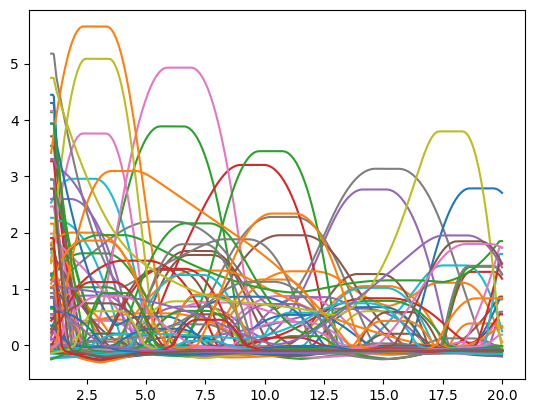

In [396]:
# convlayer: Elles sont smooth!! (en apparence du moins)
fd(Conv_out[:,1,:].detach().cpu(),grid_points=linspace(1,T,Conv_out.shape[2])).plot()
plt.show()

In [1067]:

for param in CNN.convlayer1.parameters():
    print(param.shape)

torch.Size([128, 1, 200])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])


In [1455]:


CNN=Compile_class().cuda().apply(weights_init_normal)
Conv_out=CNN.convlayer1(CNN.Granulator(x_train[:96,:]))
Conv_out2=CNN.convlayer2(Conv_out)
Conv_out3=CNN.convlayer3(Conv_out2)

[CNN.Granulator(x_train).shape,Conv_out.shape]
[CNN.Granulator(x_train).shape,Conv_out.shape,Conv_out2.shape]
[CNN.Granulator(x_train).shape,Conv_out.shape,Conv_out2.shape,Conv_out3.shape]


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_9256\2903414513.py:124: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]


[torch.Size([390, 1, 2000]),
 torch.Size([96, 128, 174]),
 torch.Size([96, 128, 64]),
 torch.Size([96, 64, 40])]

In [1456]:


lr_adam=0.000089##ADAM 9e-5 batch=96
lr_sgd=0.001 ##SGD 0.01 batch_size=78
batch_size=96
betas=[0.5,0.999]
optimizer=optim.Adam(CNN.parameters(),lr=lr_adam,betas=betas)
# optimizer=optim.SGD(CNN.parameters(),lr=lr_sgd)
loss_function=nn.CrossEntropyLoss()
CNN.n_conv_out*n_conv_in3

2560

In [1457]:
import random
from tqdm import tqdm

def train(n_epochs):
    for epoch in tqdm(range(n_epochs)):
        train_loss = torch.tensor(0).cuda().long()
        
        # Mélanger les données d'entraînement
        indices = list(range(len(x_train)))
        random.shuffle(indices)
        
        batch_index = 0  # Indice de batch
        
        for i in tqdm(range(int(len(x_train) / batch_size))):
            # Obtenir les indices des données mélangées
            batch_indices = indices[batch_index:batch_index+batch_size]
            
            functions_train = x_train[batch_indices,:,:]
            labels_train = y_train[batch_indices]
            
            optimizer.zero_grad()
            output = CNN(functions_train)
            loss = loss_function(input=output, target=labels_train)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.long()
            
            batch_index += batch_size  # Passer au prochain batch
            
        return train_loss, loss


In [1458]:
train(1)
print("Précision moyenne =",((torch.sum(torch.argmax(CNN(x_test),dim=1)==y_test)/x_test.shape[0])*100).detach().cpu().numpy(),"%")

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_9256\2903414513.py:124: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
  0%|          | 0/1 [00:00<?, ?it/s]


Précision moyenne = 90.0 %


In [1066]:


# CNN=Compile_class().cuda().apply(weights_init_normal)
Conv_out=CNN.convlayer1(CNN.Granulator(x_train[:96,:]))
Conv_out2=CNN.convlayer2(Conv_out)
Conv_out3=CNN.convlayer3(Conv_out2)

[CNN.Granulator(x_train).shape,Conv_out.shape]
[CNN.Granulator(x_train).shape,Conv_out.shape,Conv_out2.shape]
[CNN.Granulator(x_train).shape,Conv_out.shape,Conv_out2.shape,Conv_out3.shape]


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_9256\2903414513.py:124: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]


[torch.Size([390, 1, 2000]),
 torch.Size([96, 128, 174]),
 torch.Size([96, 128, 64]),
 torch.Size([96, 64, 40])]

In [18]:

#    # convlayer: Elles sont smooth!! (en apparence du moins)
# #ATTENTION, LES CONVLAYER NE SONT PAS FORCEMENT SMOOTH
# for i in range(10):
#     print("X_test" ,i+1, " ème fonction (smooth par Bspline)")
#     fd(x_test[i,0,:].cpu(),grid_points=grid_points).to_basis(basis).plot()
#     plt.show()
#     for j in range(3):    
#         fd(CNN.convlayer1(CNN.Granulator(x_test))[i,j,:].detach().cpu(),grid_points=linspace(1,T,CNN.convlayer1(CNN.Granulator(x_test)).shape[2])).plot()
#         print("Convlayer1 de x_test", i+1,"ème fonction",j+1,"ème sortie de convolution")
#         plt.show()


In [209]:
from tqdm import tqdm

def HyperparameterSearch(n_conv_in=128,n_conv_in2=64,n_conv_in3=32,n_Flat_out=256,stride_1=3,stride_2=2,stride_3=1,stride_pool_1=3,stride_pool_2=2,stride_pool_3=1,kernel_size_1=20,kernel_size_2=25,kernel_size_3=30,kernel_size_pool_1=3,kernel_size_pool_2=3,kernel_size_pool_3=3,dilation_1=1,dilation_2=1,dilation_3=1,dilation_pool_1=1,dilation_pool_2=1,dilation_pool_3=1,n_epochs=1,opt="Adam",lr=0.0001,batch_size=batch_size):
    CNN=Smooth_Strides_FCNN(
        n_conv_out=64,
        n_conv_in=n_conv_in,
        n_conv_in2=n_conv_in2,
        n_conv_in3=n_conv_in3,
        n_Flat_out=n_Flat_out,
        stride_1=stride_1,
        stride_2=stride_2,
        stride_3=stride_3,
        stride_pool_1=stride_pool_1,
        stride_pool_2=stride_pool_2,
        stride_pool_3=stride_pool_3,
        kernel_size_1=kernel_size_1,
        kernel_size_2=kernel_size_2,
        kernel_size_3=kernel_size_3,
        kernel_size_pool_1=kernel_size_pool_1,
        kernel_size_pool_2=kernel_size_pool_2,
        kernel_size_pool_3=kernel_size_pool_3,
        dilation_1=dilation_1,
        dilation_2=dilation_2,
        dilation_3=dilation_3,
        dilation_pool_1=dilation_pool_1,
        dilation_pool_2=dilation_pool_2,
        dilation_pool_3=dilation_pool_3,).cuda().apply(weights_init_normal)
    
    precision=torch.tensor([0]).cuda()
    Mean_accuracy=torch.tensor([0]).cuda()
    CNN=Smooth_Strides_FCNN(1).cuda().apply(weights_init_normal)

    Conv_out=CNN.convlayer1(CNN.Granulator(x_train))
    Conv_out2=CNN.convlayer2(CNN.convlayer1(CNN.Granulator(x_train)))
    Conv_out3=CNN.convlayer3(CNN.convlayer2(CNN.convlayer1(CNN.Granulator(x_train))))
    n_conv_out=Conv_out3.shape[2]
    
    CNN=Smooth_Strides_FCNN(n_conv_out=n_conv_out).cuda().apply(weights_init_normal)
    print (CNN.n_conv_out)

    lr_adam=lr ##ADAM 9e-5 batch=96 ##SGD 0.01 batch_size=78
    batch_size=batch_size
    betas=[0.5,0.999]
    if (opt=="Adam"):
        optimizer=optim.Adam(CNN.parameters(),lr=lr_adam,betas=betas)
    
    else:
         optimizer=optim.SGD(CNN.parameters(),lr=lr_sgd)
    loss_function=nn.CrossEntropyLoss()
    train(n_epochs=n_epochs)
    accuracy=torch.tensor([0]).cuda()
    precision=torch.tensor([0]).cuda()
    for i in range(int(len(x_test)/10)):
        outputs=torch.argmax(CNN(x_test[(i*10):(10*(i+1))]),dim=1)
        real_labels=y_test[(i*10):(10*(i+1))]
        Batch_precision=torch.sum(real_labels==outputs)/10
        accuracy=(accuracy+Batch_precision)/2
        Mean_accuracy=accuracy.cuda()

    precision=torch.cat([precision,Mean_accuracy],dim=0)
    



    


    print('Précision moyenne','=', np.array((precision.float().cpu()*100)),"%")
    

    import gc
    torch.cuda.empty_cache()
    gc.collect()


    return precision



In [21]:
CNN

Smooth_Strides_FCNN(
  (Relu): ReLU()
  (convlayer1): Sequential(
    (0): Conv1d(1, 256, kernel_size=(45,), stride=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.18)
    (3): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.18)
  )
  (convlayer2): Sequential(
    (0): Conv1d(256, 128, kernel_size=(35,), stride=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.18)
    (3): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.18)
  )
  (convlayer3): Sequential(
    (0): Conv1d(128, 64, kernel_size=(20,), stride=(1,))
    (1): Ba

In [24]:
HyperparameterSearch()

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_17572\685557426.py:74: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]


OutOfMemoryError: CUDA out of memory. Tried to allocate 746.00 MiB (GPU 0; 6.00 GiB total capacity; 12.45 GiB already allocated; 0 bytes free; 12.63 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
accuracy=torch.tensor([0]).cuda()
precision=torch.tensor([0]).cuda()
for i in range(int(len(x_test)/10)):
    outputs=torch.argmax(CNN(x_test[(i*10):(10*(i+1))]),dim=1)
    real_labels=y_test[(i*10):(10*(i+1))]
    Batch_precision=torch.sum(y_test[(i*10):10*(i+1)]==outputs)/10
    accuracy=(accuracy+Batch_precision)/2
    Mean_accuracy=accuracy.cuda()

precision=torch.cat([precision,Mean_accuracy],dim=0)
precision





NameError: name 'torch' is not defined

In [ ]:
HyperparameterSearch(
n_conv_in=128,
n_conv_in2=64,
n_conv_in3=32,
n_Flat_out=128,
stride_1=12,
stride_2=6,
stride_3=1,
stride_pool_1=2,
stride_pool_2=2,
stride_pool_3=1,
kernel_size_1=20,
kernel_size_2=25,
kernel_size_3=10,
kernel_size_pool_1=3,
kernel_size_pool_2=3,
kernel_size_pool_3=3,
dilation_1=1,
dilation_2=1,
dilation_3=1,
dilation_pool_1=1,
dilation_pool_2=1,
dilation_pool_3=1,
opt="Adam",
lr=0.00008,
n_epochs=10
)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_13692\503112799.py:67: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
100%|██████████| 10/10 [01:51<00:00, 11.17s/it]


Précision moyenne = [ 0.       41.225586] %


tensor([0.0000, 0.4123], device='cuda:0')

In [ ]:
precision=torch.tensor([0])
Mean_accuracy=torch.tensor([0])
precision=torch.cat([precision,Mean_accuracy],dim=0)
precision

tensor([0, 0])

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

64543